In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()

# Override the default linewidth and markersize
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 5

from datetime import datetime
import utils

In [2]:
TARGET_TEST_CUTOFF_DATE = '2023-08-09T08:00:00'

Data prep

In [3]:
df = pd.read_csv('fajl_za_treniranje_1.csv')
df = df.set_index('datetime')
df.index = pd.to_datetime(df.index)

In [4]:
df.head()

,temp,pe
datetime,,
2020-11-30 09:00:00,1.0,348.8
2020-11-30 10:00:00,1.9,351.9
2020-11-30 11:00:00,3.0,348.8
2020-11-30 12:00:00,3.0,325.2
2020-11-30 13:00:00,3.0,312.0


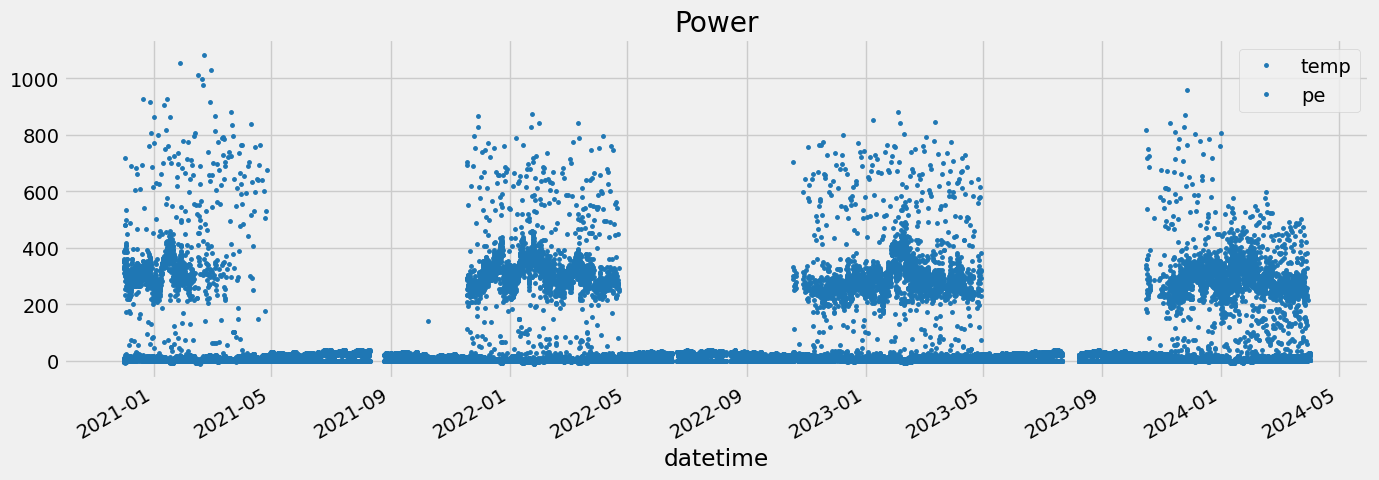

In [5]:
df.plot(style='.',
        figsize=(15, 5), 
        color=color_pal[0], 
        title='Power')
plt.show()

In [6]:
train = df.loc[df.index < TARGET_TEST_CUTOFF_DATE]
test = df.loc[df.index >= TARGET_TEST_CUTOFF_DATE]

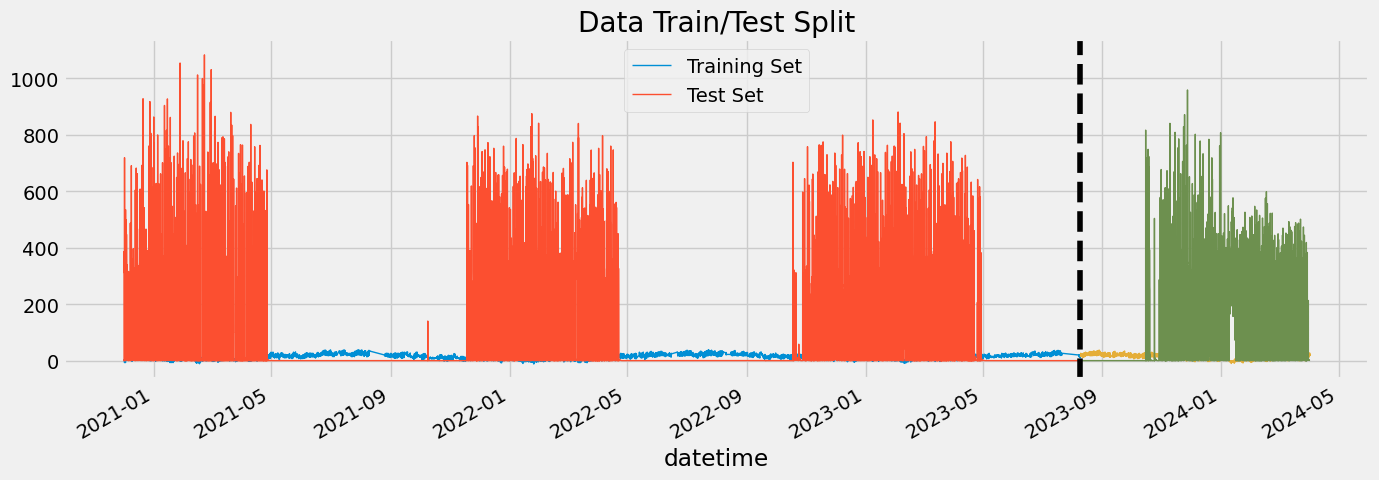

In [7]:
#Plot the Train / Test Split data
utils.plot_train_test_split(df, TARGET_TEST_CUTOFF_DATE)


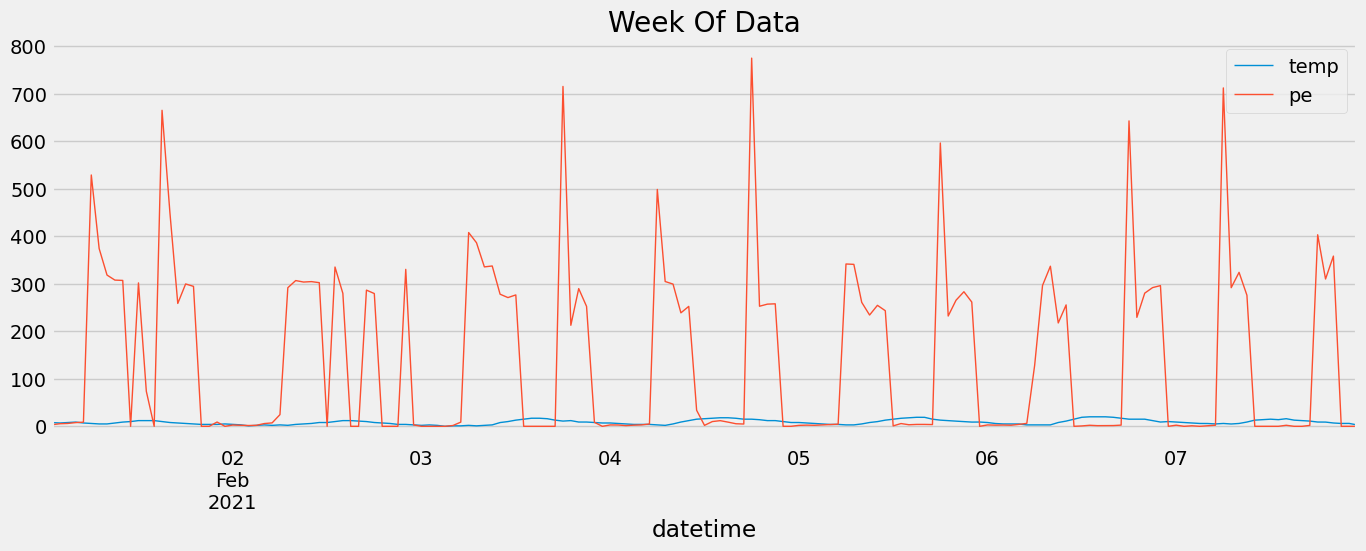

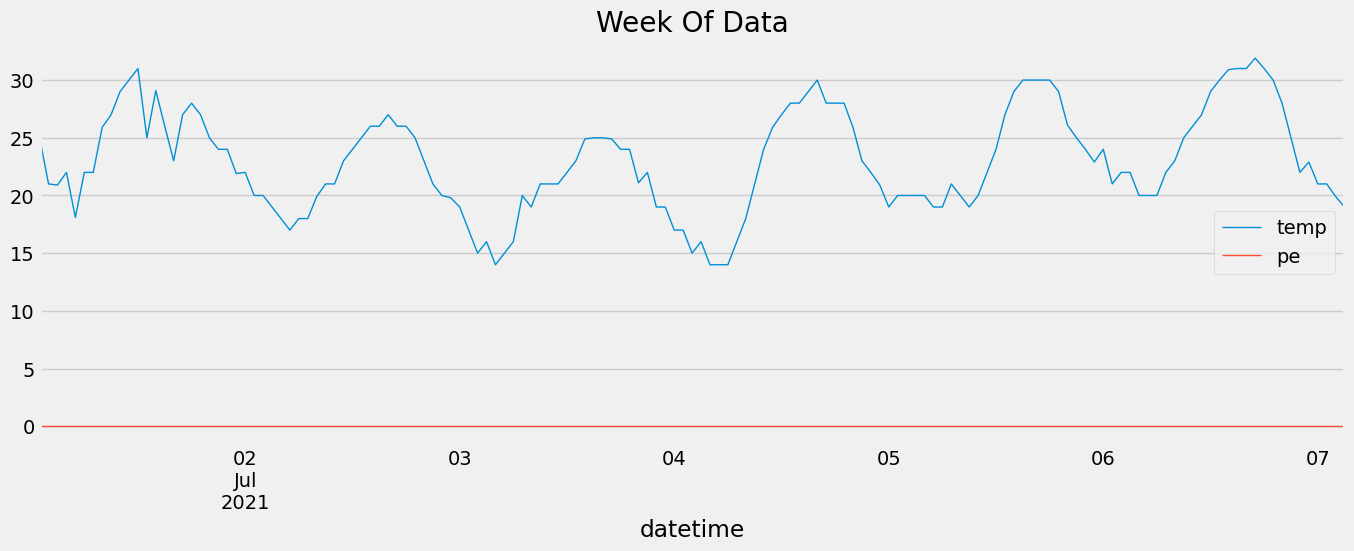

In [8]:
#Just want see how a single weekly data looks like

utils.plot_week_of_data(df, '02-01-2021', '02-08-2021')
utils.plot_week_of_data(df, '07-01-2021', '07-08-2021')

In [9]:
#From DataTime column of the original DF create features for TIme Series
df = utils.create_time_series_features(df)


In [10]:
#Visualize our Feature / Target Relationship
df.head()

,temp,pe,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
datetime,,,,,,,,,,
2020-11-30 09:00:00,1.0,348.8,9,0,4,11,2020,335,30,49
2020-11-30 10:00:00,1.9,351.9,10,0,4,11,2020,335,30,49
2020-11-30 11:00:00,3.0,348.8,11,0,4,11,2020,335,30,49
2020-11-30 12:00:00,3.0,325.2,12,0,4,11,2020,335,30,49
2020-11-30 13:00:00,3.0,312.0,13,0,4,11,2020,335,30,49


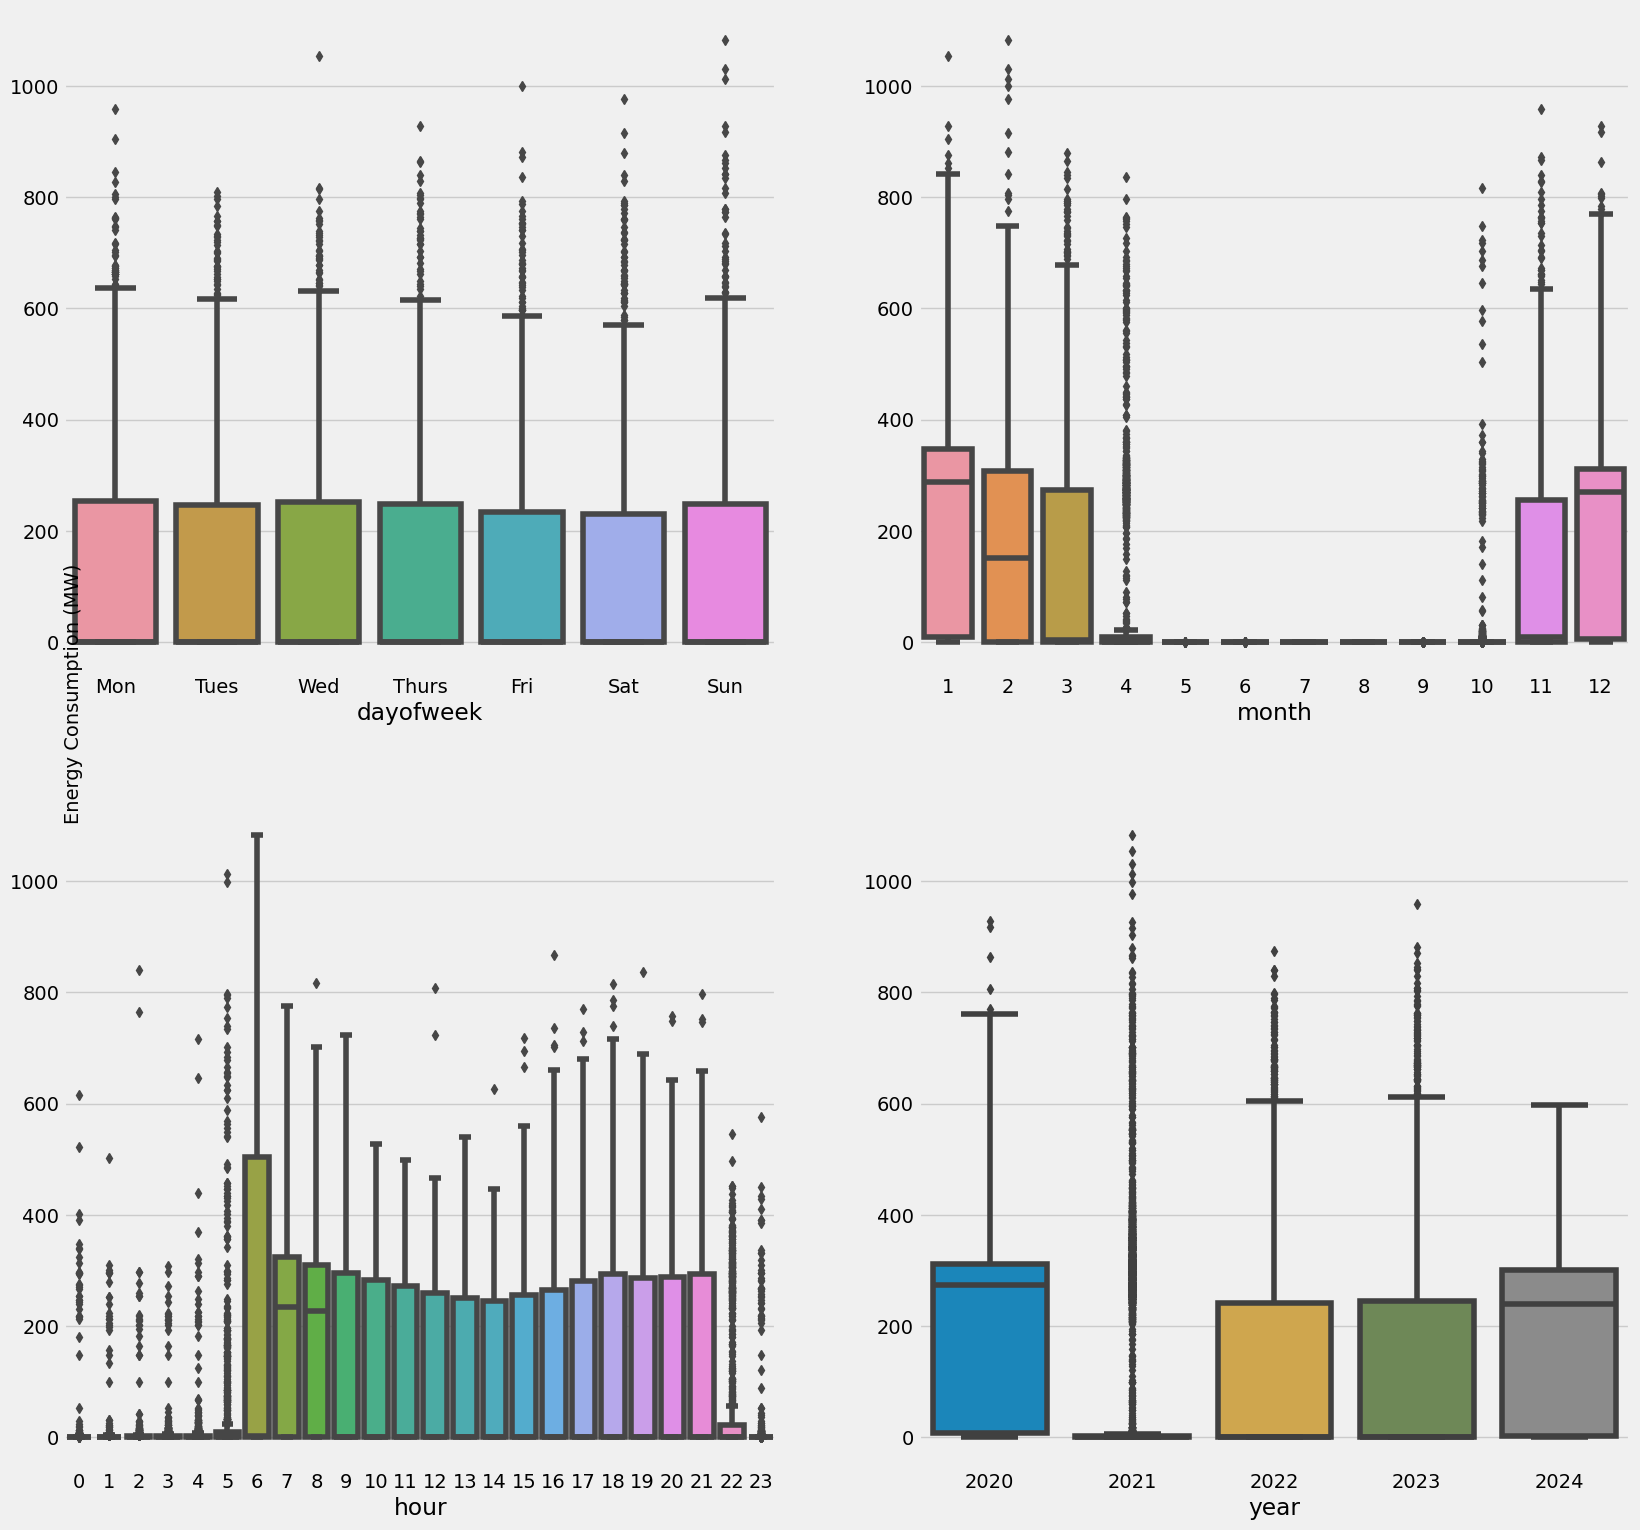

In [11]:
def plot_time_series(df, dependent_var):
    """
    This function generates a 2x2 grid of boxplots to visualize the time series data.
    ( this function assumes that the input dataframe has columns named dayofweek, month, hour, and year. If your dataframe uses different column names for these time-related variables, you should modify the function accordingly.)
    
    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing the time series data.
        
    dependent_var : str
        The column name of the dependent variable in the dataframe.
        
    Returns
    -------
    None
    """
    
    # Assert if the required columns are present in the dataframe
    assert 'dayofweek' in df.columns, "Input dataframe must have a 'dayofweek' column"
    assert 'month' in df.columns, "Input dataframe must have a 'month' column"
    assert 'hour' in df.columns, "Input dataframe must have an 'hour' column"
    assert 'year' in df.columns, "Input dataframe must have a 'year' column"
    assert dependent_var in df.columns, f"Input dataframe must have a '{dependent_var}' column"
    """ this function assumes that the input dataframe has columns named dayofweek, month, hour, and year. If your dataframe uses different column names for these time-related variables, you should modify the function accordingly. """
    
    # Initialize the figure with a 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(18,18))
    
    # Day of Week
    dow_labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
    g = sns.boxplot(x=df.dayofweek, y=df[dependent_var], ax=axes[0][0])
    g.set_xticklabels(dow_labels)
    g.set_ylabel('')
    
    # Month of Year
    g = sns.boxplot(x=df.month, y=df[dependent_var], ax=axes[0][1])
    g.set_ylabel('')
    
    # Hour of Day
    g = sns.boxplot(x=df.hour, y=df[dependent_var], ax=axes[1][0])
    g.set_ylabel('')
    
    # Year
    g = sns.boxplot(x=df.year, y=df[dependent_var], ax=axes[1][1])
    g.set_ylabel('')
    
    # Set the title for the y-axis
    fig.text(0.08, 0.5, 'Energy Consumption (MW)', va='center', rotation='vertical')
    
    # Display the plot
    plt.show()

plot_time_series(df, 'pe')

In [12]:
df_dup = df.copy()
years_months = df_dup.groupby(['year', 'month']).mean().reset_index()
years_months.head()

,year,month,temp,pe,hour,dayofweek,quarter,dayofyear,dayofmonth,weekofyear
0,2020,11,1.380000,301.213333,16.000000,0.000000,4.0,335.000000,30.000000,49.0
1,2020,12,5.476851,205.520054,11.484522,2.907133,4.0,351.002692,16.002692,50.870794
2,2021,1,3.051075,233.840995,11.500000,3.193548,1.0,16.000000,16.000000,7.387097
3,2021,2,5.424702,91.604018,11.500000,3.000000,1.0,45.500000,14.500000,6.5
4,2021,3,5.483671,50.174494,11.527665,2.794872,1.0,74.962213,15.962213,10.738192


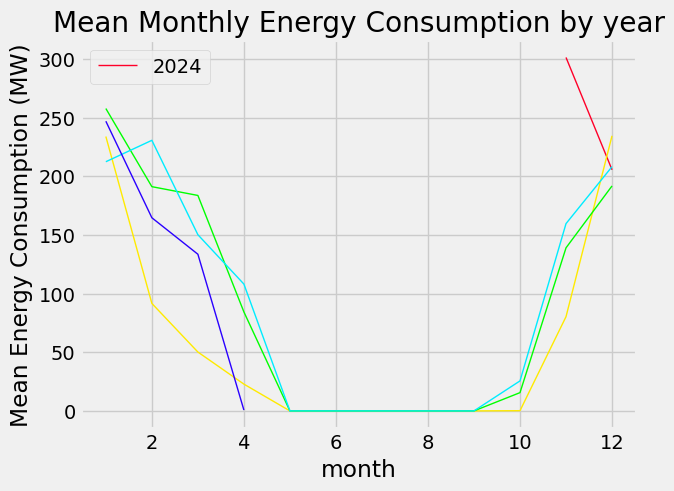

In [13]:
import matplotlib.pyplot as plt

def plot_monthly_consumption(df, dependent_var):
    """
    This function generates a line plot of the mean monthly energy consumption for each year.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing the time series data.
        
    dependent_var : str
        The column name of the dependent variable in the dataframe.
        
    Returns
    -------
    None
    """
    
    
    # Assert if the required columns are present in the dataframe
    assert 'year' in df.columns, "Input dataframe must have a 'year' column"
    assert 'month' in df.columns, "Input dataframe must have a 'month' column"
    assert dependent_var in df.columns, f"Input dataframe must have a '{dependent_var}' column"
    """ Please note that this function assumes that the input dataframe has columns named year and month, and the column representing the dependent variable (in this case, 'PJME_MW'). If your dataframe uses different column names for these variables, you should modify the function accordingly. """

    df_copy = df.copy()

    # Group data by year and month, and compute the mean for each group
    year_group = df_copy.groupby(['year', 'month']).mean().reset_index()
    
    # Get the unique years from the dataframe
    years = df_copy['year'].unique()
    NUM_COLORS = len(years)

    # Prepare color mapping
    cm = plt.get_cmap('gist_rainbow')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

    # Plot the mean monthly consumption for each year
    for i, y in enumerate(years):
        df_copy = year_group[year_group['year'] == y]
        plt.plot(df_copy['month'], df_copy[dependent_var], linewidth=1, markersize=5)
    
    plt.title('Mean Monthly Energy Consumption by year')
    plt.xlabel('month')
    plt.ylabel('Mean Energy Consumption (MW)')
    plt.legend(df_copy.year.unique())
    plt.show()

plot_monthly_consumption(df, 'pe')

In [14]:
#!pip install statsmodels

In [15]:
train.head()

,temp,pe
datetime,,
2020-11-30 09:00:00,1.0,348.8
2020-11-30 10:00:00,1.9,351.9
2020-11-30 11:00:00,3.0,348.8
2020-11-30 12:00:00,3.0,325.2
2020-11-30 13:00:00,3.0,312.0


In [16]:
train = utils.create_time_series_features(train)
test = utils.create_time_series_features(test)
train.head(2)

,temp,pe,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
datetime,,,,,,,,,,
2020-11-30 09:00:00,1.0,348.8,9,0,4,11,2020,335,30,49
2020-11-30 10:00:00,1.9,351.9,10,0,4,11,2020,335,30,49


In [17]:
#In above the weekofyear is of UInt32 dtype - So getting below error if I run XGBoost directly with it.

train['weekofyear'] = train['weekofyear'].astype('int32')
test['weekofyear'] = test['weekofyear'].astype('int32')

In [18]:
time_series_features = ['dayofyear', 'hour', 'dayofweek', 'weekofyear', 'quarter', 'month', 'year']
time_series_target = 'pe'

X_train = train[time_series_features]
y_train = train[time_series_target]

X_test = test[time_series_features]
y_test = test[time_series_target]

In [19]:
X_train.head(2)

,dayofyear,hour,dayofweek,weekofyear,quarter,month,year
datetime,,,,,,,
2020-11-30 09:00:00,335,9,0,49,4,11,2020
2020-11-30 10:00:00,335,10,0,49,4,11,2020


In [20]:
y_test.head(2)

datetime
2023-08-09 08:00:00    0.0
2023-08-09 09:00:00    0.0
Name: pe, dtype: float64

In [21]:
pip install --upgrade xgboost gpu

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: xgboost in c:\users\maja\anaconda3\lib\site-packages (2.0.3)



ERROR: Could not find a version that satisfies the requirement gpu (from versions: none)
ERROR: No matching distribution found for gpu


In [22]:
model = utils.train_xgb_regressor(X_train, y_train, X_test, y_test, use_gpu=False)

[0]	validation_0-rmse:176.87232	validation_1-rmse:198.81701


C:\Users\Maja\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [15:08:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:105.02502	validation_1-rmse:116.42029
[200]	validation_0-rmse:84.97535	validation_1-rmse:98.94566
[300]	validation_0-rmse:78.52028	validation_1-rmse:95.87076
[400]	validation_0-rmse:75.62775	validation_1-rmse:95.33065
[478]	validation_0-rmse:74.38339	validation_1-rmse:95.66341


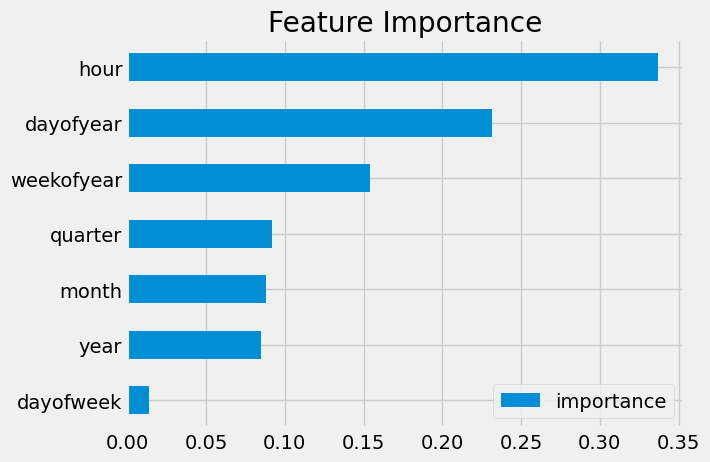

In [23]:
utils.plot_feature_importance(model)

In [24]:
test['prediction'] = model.predict(X_test)

df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

df.tail(2)

,temp,pe,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
datetime,,,,,,,,,,,
2024-04-01 00:00:00,20.0,0.70,0,0,2,4,2024,92,1,14,32.334267
2024-04-01 01:00:00,17.0,0.75,1,0,2,4,2024,92,1,14,32.355610


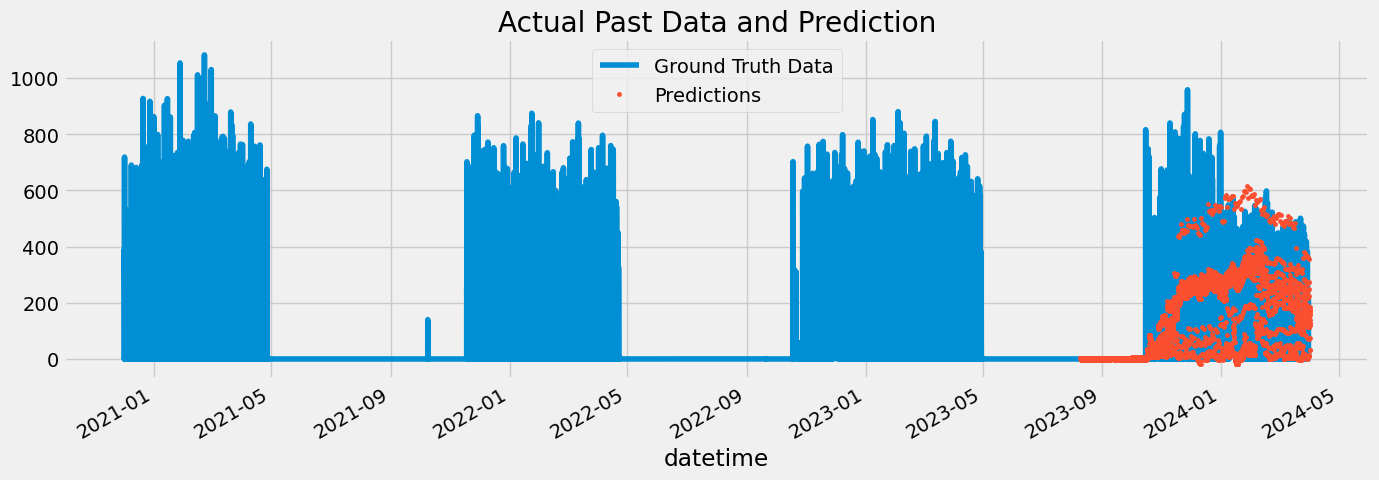

In [25]:
ax = df[['pe']].plot(figsize=(15, 5))

df['prediction'].plot(ax=ax, style='.')
plt.legend(['Ground Truth Data', 'Predictions'])
ax.set_title('Actual Past Data and Prediction')
plt.show()

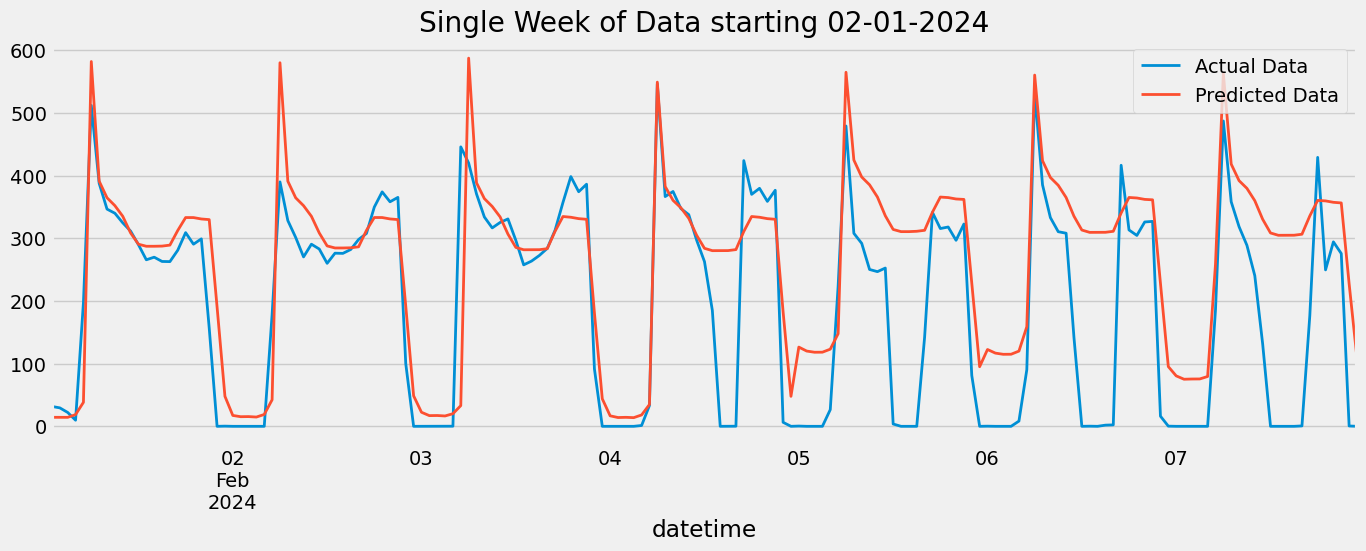

In [26]:
# select data within a specific date range
data = df.loc[(df.index > '02-01-2024') & (df.index < '02-08-2024')]

# plot the actual and predicted data
ax = data['pe'].plot(figsize=(15, 5), title='Single Week of Data starting 02-01-2024', linewidth=2, markersize=5)

data['prediction'].plot(style='-', linewidth=2, markersize=5)

plt.legend(['Actual Data', 'Predicted Data'])
plt.show()


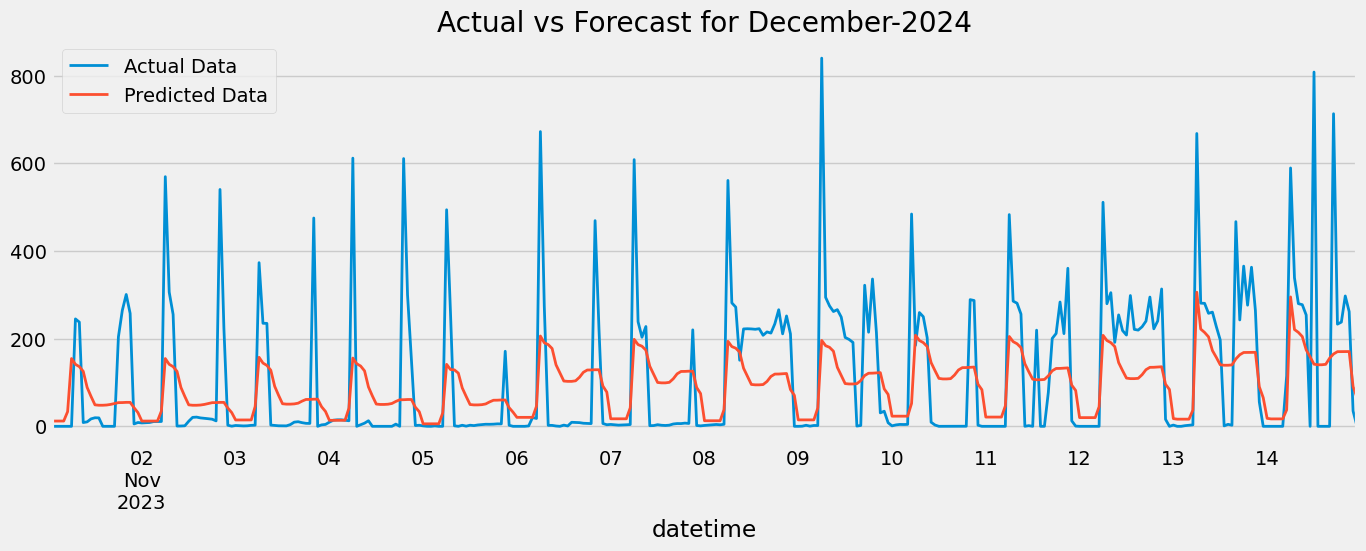

In [27]:
# select data within a specific date range
data = df.loc[(df.index > '11-01-2023') & (df.index < '11-15-2023')]

# plot the actual portion
ax = data['pe'].plot(figsize=(15, 5), title='Actual vs Forecast for December-2024', linewidth=2, markersize=5)

# plot the predicted portion
data['prediction'].plot(style='-', linewidth=2, markersize=5)

plt.legend(['Actual Data','Predicted Data'])
plt.show()


In [29]:
score = np.sqrt(mean_squared_error(test['pe'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 95.29


In [30]:
#Sort Predictions by Error values
test['error'] = np.abs(test[time_series_target] - test['prediction'])

test['date'] = test.index.date

test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2024-02-08    160.200034
2024-02-11    160.032861
2024-01-11    155.518715
2024-02-10    153.891701
2023-12-01    151.600671
2024-01-12    151.417837
2023-10-17    143.706745
2024-03-31    143.656475
2023-10-16    143.634420
2024-02-07    142.677477
Name: error, dtype: float64